# Deep learning-based recommendation system
 
**프로젝트 소개**   
`나만의 딥러닝 기반 추천 시스템 구축하기`는 AutoInt 모델을 직접 구현해보고 최종적으로 스트림릿(Streamlit)을 활용해 시각화하는 과정이다.  

스트림릿을 사용하여 시각화를 하는 이유는 <u>'추천 시스템 결과가 어떻게 나오는지'</u>를 시각적으로 살펴 보면서 관련 실무자들과 소통하기 위해서이다.  
아무리 좋은 모델을 만들어도 모델의 높은 정확도나 랭킹 지표만으로 다른 분야의 개발자, 관련 실무자, AI를 모르시는 분들을 설득하는 것은 쉽지 않다.   
모델의 정확도나 랭킹 지표가 높게 나오는 것이 아니라, <u>'실제 결과가 어떻게 나오느냐' </u> 가 더 중요하기 때문이다.  
그래서 **PoC(Proof of Concept)** 형태로 결과를 확인하는 것을 더 선호한다.

> **POC란?**  
  개념 증명 또는 개념 실증이라고 불리는 POC(Proof of Concept)는 기존 시장에 없었던 신기술을 도입하기 전에 이를 검증하기 위해 사용하는 과정



**프로젝트 순서**
1. 데이터 분석
2. 데이터 전처리
3. AutoInt 모델 구현 및 학습
4. 스트림릿을 통한 시각화
5. AutoInt+ 모델 구현 및 시각화

## Implementing and training AutoInt models
AutoInt 모델
- 멀티헤드 셀프 어텐션(multi-head self-attention)구조를 활용해 입력 피처들간의 상호작용과 관계성을 모델링
- 쌓아올린 구조(stack)를 통해 서로 다른 차원에서 피처 상호작용 학습
- 고차 상호작용을 명시적(explicitly) & 자동(automatic)으로 학습

In [1]:
import time
import random
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Conv2D, Dropout, Lambda, Dense, Flatten, Activation, Input, Embedding, BatchNormalization
from tensorflow.keras.initializers import glorot_normal, Zeros, TruncatedNormal
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import math

### Layer definition
AutoInt에 사용되는 Layer는 총 3가지이다.

1. 임베딩 레이어
    - 임베딩 레이어는 raw input 데이터를 저차원 임베딩 공간에 매핑하는 과정
    - 예를 들어 성별이 남, 여가 있다면 이는 각각 0과 1로 매핑될 수 있고, 0에 해당되는 32차원 임베딩 공간, 1에 해당되는 임베딩 공간에 매핑하는 과정이다.
2. 다층 퍼셉트론(MLP-Multilayer Perceptron, DNN 구조)
    - 딥러닝을 배우면 거의 가장 먼저 배울 수 있는 구조
    - 비선형 레이어를 쌓아올린 구조
        - Dense layer를 쌓아올린 구조라고 보면 된다.
3. 멀티 헤드 어텐션
    - 쿼리(query), 키(key), 값(value)에 따른 어텐션을 계산하는 구조
    - 본 모델에서는 셀프 어텐션 구조로 진행된다.

#### Embedding layer

In [2]:
class FeaturesEmbedding(Layer):  
    '''
    임베딩 레이어 
    - 만약 피처(feature) 3개가 각각 10개, 20개, 30개의 고유값을 가진다면 feature_dims는 [10, 20, 30] 형태를 띄게 된다.
    - 전체 임베딩을 해야 할 개수는 10+20+30 = 60이므로 '60 x 임베딩_차원_크기'의 행렬이 생성되게 된다.
    '''
    def __init__(self, field_dims, embed_dim, **kwargs):
        super(FeaturesEmbedding, self).__init__(**kwargs)
        self.total_dim = sum(field_dims)
        self.embed_dim = embed_dim
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.longlong)
        self.embedding = tf.keras.layers.Embedding(input_dim=self.total_dim, output_dim=self.embed_dim)

    def build(self, input_shape):
        # 임베딩을 빌드하고 초기화
        self.embedding.build(input_shape)
        self.embedding.set_weights([tf.keras.initializers.GlorotUniform()(shape=self.embedding.weights[0].shape)])

    def call(self, x):
        # 들어온 입력의 임베딩을 가져오기
        x = x + tf.constant(self.offsets)
        return self.embedding(x)

#### Multilayer Perceptron

In [3]:
class MultiLayerPerceptron(Layer):  
    '''
    DNN 레이어
    - Tensorflow Keras에서는 Dense 레이어를 쌓아올린 구조
    - 필요에 따라 배치 정규화도 사용할 수 있다.
    '''
    def __init__(self, input_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, init_std=0.0001, output_layer=True):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        hidden_units = [input_dim] + list(hidden_units)
        if output_layer:
            hidden_units += [1]
        # Dense layer를 쌓아올린다.
        self.linears = [Dense(units, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=init_std),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)) for units in hidden_units[1:]]
        # 활성화 함수 세팅
        self.activation = tf.keras.layers.Activation(activation)
        # 필요하다면 배치정규화도 진행
        if self.use_bn:
            self.bn = [BatchNormalization() for _ in hidden_units[1:]]
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.linears)):
            # input data가 들어오면 layer를 돌면서 벡터 값을 가져오게 된다.
            x = self.linears[i](x)
            if self.use_bn:
                x = self.bn[i](x, training=training)
            # 각 layer마다 나온 벡터 값에 활성화 함수와 dropout을 적용시켜 비선형성 구조와 과적합 방지
            x = self.activation(x)
            x = self.dropout(x, training=training)
        return x

#### 멀티 헤드 어텐션
트랜스포머와 동일한 구조
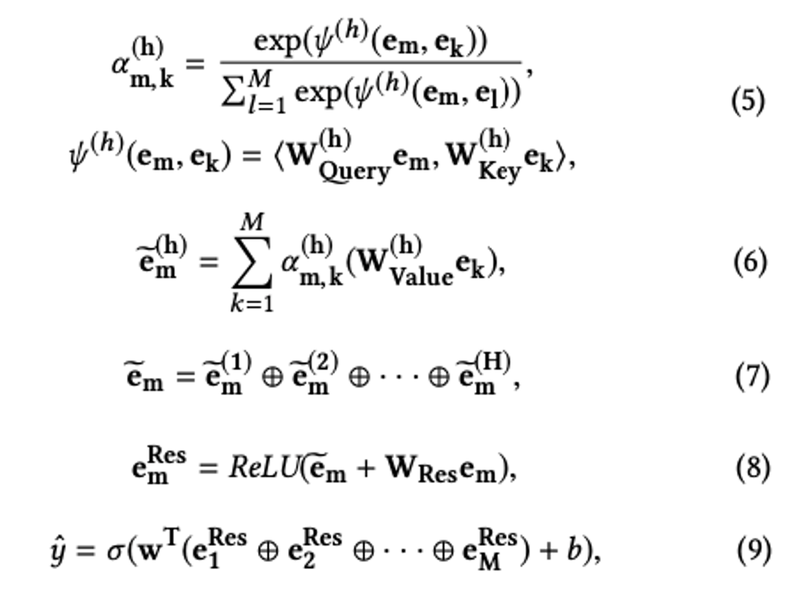

In [4]:
class MultiHeadSelfAttention(Layer):  
    '''
    멀티 헤드 셀프 어텐션 레이어
    - 식과 같이 동작
    - 필요에 따라 잔차 연결(residual connection)도 진행
    '''
    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, scaling=False, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        self.scaling = scaling
        super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        embedding_size = int(input_shape[-1])
        # 쿼리에 해당하는 매트릭스
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed))
        # 키에 해당되는 매트릭스
        self.W_key = self.add_weight(name='key', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                     dtype=tf.float32,
                                     initializer=TruncatedNormal(seed=self.seed + 1))
        # 값(value)에 해당되는 매트릭스
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed + 2))
        # 필요하다면 잔차 연결도 할 수 있다.
        if self.use_res:
            self.W_Res = self.add_weight(name='res', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                         dtype=tf.float32,
                                         initializer=TruncatedNormal(seed=self.seed))

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))
        
        # 입력이 들어오면 쿼리, 키, 값(value)에 매칭되어 각각의 값을 가지고 온다.
        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))  
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))

        # 헤드 개수에 따라 데이터 분리
        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))
        
        # 쿼리와 키를 먼저 곱해준다. 위 이미지의 식 (5)와 같다.
        inner_product = tf.matmul(querys, keys, transpose_b=True)
        if self.scaling:
            inner_product /= self.att_embedding_size ** 0.5
        self.normalized_att_scores =  tf.nn.softmax(inner_product)
        
        # 쿼리와 키에서 나온 어텐션 값을 값(value)에 곱해준다. 식 (6)과 같다.
        result = tf.matmul(self.normalized_att_scores, values)
        # 식 (7)과 같이 쪼개어진 멀테 헤드를 모아준다.
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)
        result = tf.squeeze(result, axis=0) 

        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        result = tf.nn.relu(result)
        
        # 결과 값 리턴

        return result

    def compute_output_shape(self, input_shape):

        return (None, input_shape[1], self.att_embedding_size * self.head_num)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num, 'use_res': self.use_res,'seed': self.seed}
        base_config = super(MultiHeadSelfAttention, self).get_config()
        base_config.update(config)
        return base_config

#### AutoInt model

In [5]:
class AutoInt(Layer): 
    '''
     AutoInt 본체
     - 앞서서 정의한 layer를 가져와서 계산을 수행
    '''
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, 
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoInt, self).__init__()
        # 임베딩 레이어 정의 
        self.embedding = FeaturesEmbedding(field_dims, embedding_size)
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size
        # 마지막 출력 레이어 정의
        self.final_layer = Dense(1, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=init_std))
        # 멀티 레이어 퍼셉트론 레이어 정의
        self.int_layers = [MultiHeadSelfAttention(att_embedding_size=embedding_size, head_num=att_head_num, use_res=att_res) for _ in range(att_layer_num)]

    def call(self, inputs):
        # input 데이터에 해당되는 embedding 값을 가져온다.
        att_input = self.embedding(inputs)
        # 멀티 헤드 셀프 어텐션 레이어에서 상호작용 수행
        for layer in self.int_layers:
            att_input = layer(att_input)

        att_output = Flatten()(att_input)
        # 최종 출력. 
        att_output = self.final_layer(att_output)
        # sigmoid로 예측값 출력
        y_pred = tf.nn.sigmoid(att_output)

        return y_pred

#### Evaluation Indicators
평가 함수는 아래의 [링크](https://www.programcreek.com/python/?code=MaurizioFD%2FRecSys2019_DeepLearning_Evaluation%2FRecSys2019_DeepLearning_Evaluation-master%2FConferences%2FKDD%2FMCRec_our_interface%2FMCRecRecommenderWrapper.py) 참고했다.

In [6]:
def get_DCG(ranklist, y_true):
    dcg = 0.0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item in y_true:
            dcg += 1.0 / math.log(i + 2)
    return  dcg

def get_IDCG(ranklist, y_true):
    idcg = 0.0
    i = 0
    for item in y_true:
        if item in ranklist:
            idcg += 1.0 / math.log(i + 2)
            i += 1
    return idcg

def get_NDCG(ranklist, y_true):
    '''NDCG 평가 지표'''
    ranklist = np.array(ranklist).astype(int)
    y_true = np.array(y_true).astype(int)
    dcg = get_DCG(ranklist, y_true)
    idcg = get_IDCG(y_true, y_true)
    if idcg == 0:
        return 0
    return round( (dcg / idcg), 5)

def get_hit_rate(ranklist, y_true):
    '''hitrate 평가 지표'''
    c = 0
    for y in y_true:
        if y in ranklist:
            c += 1
    return round( c / len(y_true), 5 )

#### Model Testing

In [7]:
def test_model(model, test_df):
    '''모델 테스트'''
    user_pred_info = defaultdict(list)
    total_rows = len(test_df)
    for i in range(0, total_rows, batch_size):
        features = test_df.iloc[i:i + batch_size, :-1].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
    return user_pred_info

## Data loading and setting

### Load data


In [8]:
data_path = './aiffel/autoint/ml-1m'
movielens_rcmm = pd.read_csv(f"{data_path}/movielens_rcmm_v2.csv", dtype=str)
print(movielens_rcmm.shape)
movielens_rcmm.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2000,12,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2000,12,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2000,12,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2000,12,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


### 라벨 인코더(label encoder)
sklearn의 [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
label은 제외한 각 컬럼을 돌면서 각각의 고윳값들을 0부터 n까지 매핑시킨다.

In [9]:
label_encoders = {col: LabelEncoder() for col in movielens_rcmm.columns[:-1]} # label은 제외

for col, le in label_encoders.items():
    movielens_rcmm[col] = le.fit_transform(movielens_rcmm[col])

movielens_rcmm.head()

,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,0,189,6,55,0,3,0,7,17,15,0,0,2,1588,1
1,0,3374,8,76,0,3,0,2,2,8,0,0,2,1588,0
2,0,3615,5,44,0,3,0,11,12,15,0,0,2,1588,0
3,0,2503,9,80,0,3,0,7,17,15,0,0,2,1588,1
4,0,1374,8,78,1,0,0,2,2,2,0,0,2,1588,1


In [10]:
movielens_rcmm['label'] = movielens_rcmm['label'].astype(np.float32)

### 학습 데이터와 테스트데이터로 분리, 0.2 정도로 분리

In [11]:
train_df, test_df = train_test_split(movielens_rcmm, test_size=0.2, random_state=42)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800167 entries, 416292 to 121958
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        800167 non-null  int64  
 1   movie_id       800167 non-null  int64  
 2   movie_decade   800167 non-null  int64  
 3   movie_year     800167 non-null  int64  
 4   rating_year    800167 non-null  int64  
 5   rating_month   800167 non-null  int64  
 6   rating_decade  800167 non-null  int64  
 7   genre1         800167 non-null  int64  
 8   genre2         800167 non-null  int64  
 9   genre3         800167 non-null  int64  
 10  gender         800167 non-null  int64  
 11  age            800167 non-null  int64  
 12  occupation     800167 non-null  int64  
 13  zip            800167 non-null  int64  
 14  label          800167 non-null  float32
dtypes: float32(1), int64(14)
memory usage: 94.6 MB


#### 필요 컬럼들과 레이블 정의
필드의 각 고유 개수를 정의하는 field_dims를 정의한다.  
이는 임베딩 때 활용된다. 

In [12]:
u_i_feature = ['user_id', 'movie_id']
meta_features = ['movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip']
label = 'label'
field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int64).values, axis=0) + 1
field_dims

array([6040, 3706,   10,   81,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439])

### 훈련 환경 및 모델 세팅
1. 드롭아웃, 배치사이즈 등 모델 훈련, 모델 설정 등의 세팅
2. 모델 정의

In [13]:
epochs = 30
learning_rate = 0.0001
dropout = 0.3
batch_size = 1024
embed_dim = 32

#### AutoInt 레이어를 가지고 있는 모델 본체, 해당 모델을 활용해 훈련 진행

In [14]:
class AutoIntModel(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2
                 , att_res=True, l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                 , dnn_dropout=0, init_std=0.0001):
        super(AutoIntModel, self).__init__()
        self.autoInt_layer = AutoInt(field_dims, embedding_size, att_layer_num=att_layer_num, att_head_num=att_head_num, 
                                     att_res=att_res, l2_reg_dnn=l2_reg_dnn, dnn_dropout=dnn_dropout, init_std=init_std
                                    )

    def call(self, inputs, training=False):
        return self.autoInt_layer(inputs, training=training)

#### 모델 정의

In [15]:
autoInt_model = AutoIntModel(field_dims, embed_dim, att_layer_num=3, att_head_num=2, att_res=True,
                             l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                             , dnn_dropout=dropout, init_std=0.0001)

#### 옵티마이저, 오차함수 정의

In [16]:
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy(from_logits=False)

In [17]:
autoInt_model.compile(optimizer=optimizer, 
                      loss=loss_fn, 
                      metrics=['binary_crossentropy'])

### 훈련 및 평가

In [18]:
history = autoInt_model.fit(train_df[u_i_feature + meta_features], 
                            train_df[label], 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_split=0.1)

Epoch 1/30
704/704 [==============================] - 22s 11ms/step - loss: 0.6200 - binary_crossentropy: 0.6200 - val_loss: 0.5556 - val_binary_crossentropy: 0.5556
Epoch 2/30
704/704 [==============================] - 7s 10ms/step - loss: 0.5417 - binary_crossentropy: 0.5417 - val_loss: 0.5443 - val_binary_crossentropy: 0.5443
Epoch 3/30
704/704 [==============================] - 7s 10ms/step - loss: 0.5355 - binary_crossentropy: 0.5355 - val_loss: 0.5427 - val_binary_crossentropy: 0.5427
Epoch 4/30
704/704 [==============================] - 7s 10ms/step - loss: 0.5339 - binary_crossentropy: 0.5339 - val_loss: 0.5422 - val_binary_crossentropy: 0.5422
Epoch 5/30
704/704 [==============================] - 7s 10ms/step - loss: 0.5329 - binary_crossentropy: 0.5329 - val_loss: 0.5417 - val_binary_crossentropy: 0.5417
Epoch 6/30
704/704 [==============================] - 7s 10ms/step - loss: 0.5323 - binary_crossentropy: 0.5323 - val_loss: 0.5416 - val_binary_crossentropy: 0.5416
Epoch 7/3

#### 예측된 정보 저장

In [19]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리 
user_pred_info = {}
# top10개
top = 10
# 테스트 값을 가지고 온다. 
mymodel_user_pred_info = test_model(autoInt_model, test_df)
# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져온다. 
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist
# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져온다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

100%|██████████| 6035/6035 [00:00<00:00, 76600.93it/s]


In [20]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate 비교

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

100%|██████████| 5994/5994 [00:00<00:00, 26758.11it/s]


In [21]:
print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

 mymodel ndcg :  0.66828
 mymodel hitrate :  0.63623


### 저장

#### 학습된 모델 저장

In [22]:
np.save('./aiffel/autoint/field_dims.npy', field_dims)

In [23]:
# 모델 저장을 위해, autoint 폴더 안에 model 폴더 생성
!mkdir ./aiffel/autoint/model/

mkdir: cannot create directory ‘./aiffel/autoint/model/’: File exists


#### 모델의 가중치(weight) 저장

In [24]:
autoInt_model.save_weights('./aiffel/autoint/model/autoInt_model_weights.h5')

#### 모델 객체 저장
모델을 저장할 때는 모델 객체도 저장해 두어야 한다.   
모델 객체는 `joblib.dump`를 이용하여 pickled binary file 형태로 저장하면 된다.

In [25]:
import joblib 

# 모델 객체를 pickled binary file 형태로 저장
joblib.dump(label_encoders, './aiffel/autoint/label_encoders.pkl')

['./aiffel/autoint/label_encoders.pkl']

## AutoInt+ model implementation

In [29]:
class AutoIntMLP(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, dnn_hidden_units=(32, 32), **kwargs):
        super(AutoIntMLP, self).__init__(**kwargs)
        self.embedding_layer = FeaturesEmbedding(field_dims, embedding_size)
        self.att_layers = [MultiHeadSelfAttention(embedding_size, att_head_num) for _ in range(att_layer_num)]
        self.dnn = MultiLayerPerceptron(embedding_size * len(field_dims), dnn_hidden_units)
        self.final_dense = Dense(1, activation=None)  # Add a final dense layer
    
    def call(self, inputs):
        embed_x = self.embedding_layer(inputs)
        att_input = embed_x
        for layer in self.att_layers:
            att_input = layer(att_input)
        att_output = Flatten()(att_input)
        
        # Ensure DNN receives the correct input shape
        dnn_input = Flatten()(embed_x)
        dnn_output = self.dnn(dnn_input)
        
        # Combine attention output and DNN output
        combined_output = tf.add(att_output, dnn_output)  # Ensure this operation is valid
        
        # Final dense layer
        y_pred = self.final_dense(combined_output)
        y_pred = tf.sigmoid(y_pred)  # Apply sigmoid activation
        return y_pred

In [30]:
field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int64).values, axis=0) + 1
embedding_size = 16
model = AutoIntMLP(field_dims, embedding_size)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(train_df[u_i_feature + meta_features], 
                            train_df[label], 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_split=0.1)

Epoch 1/30
704/704 [==============================] - 9s 9ms/step - loss: 0.5722 - accuracy: 0.7000 - val_loss: 0.5463 - val_accuracy: 0.7240
Epoch 2/30
704/704 [==============================] - 6s 9ms/step - loss: 0.5396 - accuracy: 0.7278 - val_loss: 0.5435 - val_accuracy: 0.7257
Epoch 3/30
704/704 [==============================] - 6s 9ms/step - loss: 0.5345 - accuracy: 0.7305 - val_loss: 0.5406 - val_accuracy: 0.7268
Epoch 4/30
704/704 [==============================] - 6s 9ms/step - loss: 0.5275 - accuracy: 0.7330 - val_loss: 0.5341 - val_accuracy: 0.7291
Epoch 5/30
704/704 [==============================] - 6s 8ms/step - loss: 0.5204 - accuracy: 0.7372 - val_loss: 0.5307 - val_accuracy: 0.7304
Epoch 6/30
704/704 [==============================] - 6s 8ms/step - loss: 0.5141 - accuracy: 0.7411 - val_loss: 0.5275 - val_accuracy: 0.7347
Epoch 7/30
704/704 [==============================] - 6s 8ms/step - loss: 0.5081 - accuracy: 0.7455 - val_loss: 0.5265 - val_accuracy: 0.7345
Epoch 

In [32]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리 
user_pred_info = {}
# top10개
top = 10
# 테스트 값을 가지고 온다. 
mymodel_user_pred_info = test_model(model, test_df)
# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져온다. 
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist
# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져온다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

100%|██████████| 6035/6035 [00:00<00:00, 77984.58it/s]


In [33]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate 비교

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

100%|██████████| 5994/5994 [00:00<00:00, 21875.16it/s]

 mymodel ndcg :  0.66342
 mymodel hitrate :  0.63381


In [34]:
np.save('./aiffel/autoint/field_dims_plus.npy', field_dims)
autoInt_model.save_weights('./aiffel/autoint/model/autoInt_model_weights_plus.h5')
joblib.dump(label_encoders, './aiffel/autoint/label_encoders_plus.pkl')

['./aiffel/autoint/label_encoders_plus.pkl']

## 회고
이 프로젝트를 통해 심층 학습 기반의 추천 시스템 개발에 필요한 전반적인 과정을 경험하였다.   
AutoInt+ 모델의 구현과 학습, 평가, 그리고 사용자 인터페이스 구현에 이르기까지, 추천 시스템 개발의 다양한 측면을 실습하였다.   
앞으로도 이러한 경험을 바탕으로 보다 발전된 모델과 사용자 경험을 제공하는 추천 시스템을 개발할 수 있기를 기대한다.

확실히 추천 시스템이 제일 좋은 거 같다.  
조금 더 공부하고 싶어졌다.